<a href="https://colab.research.google.com/github/Faizdk/UAS_PDM/blob/main/22_11_4627_Faiz_Daffa_Kurnia_pdm7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Faiz Daffa Kurnia<br>
NIM : 22.11.4627<br>
KELAS : PDM7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing dan EDA

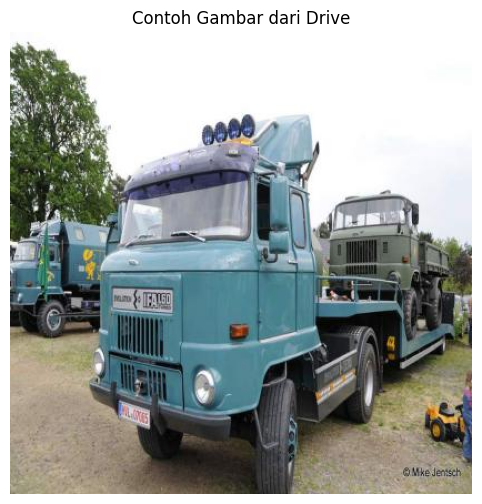

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

dataset_path = '/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset'

# Ambil satu gambar
img_dir = os.path.join(dataset_path, "train", "images")
img_file = os.listdir(img_dir)[0]
img_path = os.path.join(img_dir, img_file)

# Baca dan konversi ke RGB
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Tampilkan
plt.figure(figsize=(8,6))
plt.imshow(img)
plt.title("Contoh Gambar dari Drive")
plt.axis("off")
plt.show()


Menghitung Jumlah File Dataset

In [ ]:
def count_images_labels(path):
    for subset in ['train', 'valid', 'test']:
        img_path = os.path.join(path, subset, 'images')
        label_path = os.path.join(path, subset, 'labels')
        img_count = len(os.listdir(img_path))
        label_count = len(os.listdir(label_path))
        print(f"{subset.upper()} : Images = {img_count}, Labels = {label_count}")

count_images_labels(dataset_path)

TRAIN : Images = 878, Labels = 878
VALID : Images = 250, Labels = 250
TEST : Images = 126, Labels = 126


Mengecek Ukuran Dataset

In [ ]:
def check_image_sizes(image_dir):
    sizes = []
    for subset in ['train', 'valid', 'test']:
        subset_dir = os.path.join(image_dir, subset, 'images')
        for img_file in os.listdir(subset_dir):
            img_path = os.path.join(subset_dir, img_file)
            img = cv2.imread(img_path)
            h, w = img.shape[:2]
            sizes.append((w, h))
    return sizes

image_sizes = check_image_sizes(dataset_path)

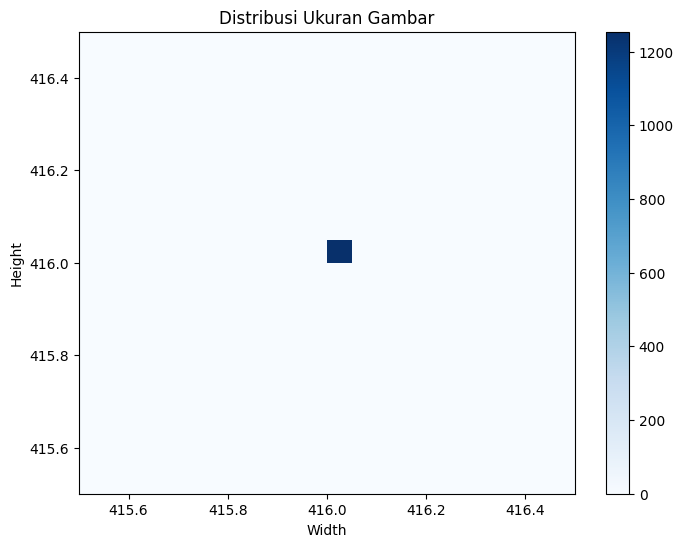

In [ ]:
import pandas as pd
size_df = pd.DataFrame(image_sizes, columns=['width', 'height'])

plt.figure(figsize=(8,6))
plt.hist2d(size_df['width'], size_df['height'], bins=(20,20), cmap='Blues')
plt.colorbar()
plt.xlabel('Width')
plt.ylabel('Height')
plt.title('Distribusi Ukuran Gambar')
plt.show()

Mengecek Format Dataset

In [ ]:
import os
from collections import Counter

# Path ke folder gambar
img_dir = os.path.join(dataset_path, 'train', 'images')

# Ambil seluruh ekstensi file
extensions = []
for file in os.listdir(img_dir):
    if os.path.isfile(os.path.join(img_dir, file)):
        ext = os.path.splitext(file)[1].lower()  # ambil ekstensi, huruf kecil
        extensions.append(ext)

# Hitung masing-masing format
ext_counter = Counter(extensions)

# Tampilkan hasil
print("Distribusi format gambar:")
for ext, count in ext_counter.items():
    print(f"{ext} : {count} file")

Distribusi format gambar:
.jpg : 878 file


Menghitung Distribusi Objek di Seluruh Kelas

In [ ]:
from collections import Counter

def count_classes(label_dir):
    class_counts = Counter()
    for file in os.listdir(label_dir):
        with open(os.path.join(label_dir, file), 'r') as f:
            for line in f.readlines():
                # Change here to handle float strings:
                class_id = int(float(line.split()[0]))
                class_counts[class_id] += 1
    return class_counts

class_names = ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']

# Gabungkan semua subset
all_labels = [os.path.join(dataset_path, "train/labels"),
              os.path.join(dataset_path, "valid/labels"),
              os.path.join(dataset_path, "test/labels")]
total_class_count = Counter()
for folder in all_labels:
    total_class_count += count_classes(folder)

print("Distribusi Kelas:")
for cls_id, count in total_class_count.items():
    class_name = class_names[cls_id] if cls_id < len(class_names) else f"Unknown({cls_id})"
    print(f"{class_name.capitalize()} (Class {cls_id}) = {count} objek")

Distribusi Kelas:
Car (Class 2) = 1302 objek
Bus (Class 1) = 282 objek
Motorcycle (Class 3) = 280 objek
Ambulance (Class 0) = 252 objek
Truck (Class 4) = 272 objek


Augmentasi Data untuk Menyeimbangkan Kelas

In [ ]:
import albumentations as A
import cv2
import os
import shutil

# Definisikan augmentasi
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.RandomGamma(p=0.3),
    A.Rotate(limit=10, p=0.5),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Kelas minor yang ingin di-augmentasi
minor_classes = [0, 1 , 3, 4]  # Ambulance, Bus, Motorcycle, Truck

# Paths
train_img_dir = os.path.join(dataset_path, 'train', 'images')
train_lbl_dir = os.path.join(dataset_path, 'train', 'labels')

# Folder baru untuk hasil augmentasi
aug_img_dir = os.path.join(dataset_path, 'train', 'images_aug')
aug_lbl_dir = os.path.join(dataset_path, 'train', 'labels_aug')
os.makedirs(aug_img_dir, exist_ok=True)
os.makedirs(aug_lbl_dir, exist_ok=True)

# Fungsi augmentasi per file
def augment_image(img_path, lbl_path, save_idx=1):
    img = cv2.imread(img_path)
    h, w = img.shape[:2]

    with open(lbl_path, 'r') as f:
        lines = f.readlines()

    bboxes = []
    class_labels = []
    for line in lines:
        parts = line.strip().split()
        cls_id, x, y, bw, bh = map(float, parts)
        if int(cls_id) in minor_classes:
            bboxes.append([x, y, bw, bh])
            class_labels.append(int(cls_id))

    if len(bboxes) == 0:
        return  # Skip gambar yang tidak mengandung minor class

    # Augmentasi
    augmented = augment(image=img, bboxes=bboxes, class_labels=class_labels)

    # Simpan gambar
    base_filename = os.path.splitext(os.path.basename(img_path))[0]
    new_img_name = f"{base_filename}_aug{save_idx}.jpg"
    new_lbl_name = f"{base_filename}_aug{save_idx}.txt"

    cv2.imwrite(os.path.join(aug_img_dir, new_img_name), cv2.cvtColor(augmented['image'], cv2.COLOR_RGB2BGR))

    # Simpan label baru
    with open(os.path.join(aug_lbl_dir, new_lbl_name), 'w') as f:
        for bbox, cls_id in zip(augmented['bboxes'], augmented['class_labels']):
            f.write(f"{cls_id} {' '.join(map(str, bbox))}\n")

# Loop semua file
for img_file in os.listdir(train_img_dir):
    img_path = os.path.join(train_img_dir, img_file)
    lbl_file = img_file.replace('.jpg', '.txt')
    lbl_path = os.path.join(train_lbl_dir, lbl_file)

    if not os.path.exists(lbl_path):
        continue  # Skip kalau label tidak ditemukan

    # Augmentasi 2x per gambar
    augment_image(img_path, lbl_path, save_idx=1)
    augment_image(img_path, lbl_path, save_idx=2)

print("Augmentasi selesai! Hasil disimpan di 'images_aug' dan 'labels_aug'")


Augmentasi selesai! Hasil disimpan di 'images_aug' dan 'labels_aug'


In [ ]:
import shutil

# Path folder augmentasi
aug_img_dir = os.path.join(dataset_path, 'train', 'images_aug')
aug_lbl_dir = os.path.join(dataset_path, 'train', 'labels_aug')

# Path folder asli
train_img_dir = os.path.join(dataset_path, 'train', 'images')
train_lbl_dir = os.path.join(dataset_path, 'train', 'labels')

# Gabungkan semua gambar
for file_name in os.listdir(aug_img_dir):
    src = os.path.join(aug_img_dir, file_name)
    dst = os.path.join(train_img_dir, file_name)
    shutil.copy(src, dst)

# Gabungkan semua label
for file_name in os.listdir(aug_lbl_dir):
    src = os.path.join(aug_lbl_dir, file_name)
    dst = os.path.join(train_lbl_dir, file_name)
    shutil.copy(src, dst)

print("Merge selesai! Semua augmentasi sudah masuk ke folder train.")

Merge selesai! Semua augmentasi sudah masuk ke folder train.


In [ ]:
all_labels = [os.path.join(dataset_path, "train/labels"),
              os.path.join(dataset_path, "valid/labels"),
              os.path.join(dataset_path, "test/labels")]
total_class_count = Counter()
for folder in all_labels:
    total_class_count += count_classes(folder)

print("Distribusi Kelas:")
for cls_id, count in total_class_count.items():
    class_name = class_names[cls_id] if cls_id < len(class_names) else f"Unknown({cls_id})"
    print(f"{class_name.capitalize()} (Class {cls_id}) = {count} objek")

Distribusi Kelas:
Car (Class 2) = 1302 objek
Bus (Class 1) = 678 objek
Motorcycle (Class 3) = 684 objek
Ambulance (Class 0) = 592 objek
Truck (Class 4) = 656 objek


Menampilkan Gambar Random dengan Bounding Box dan Label

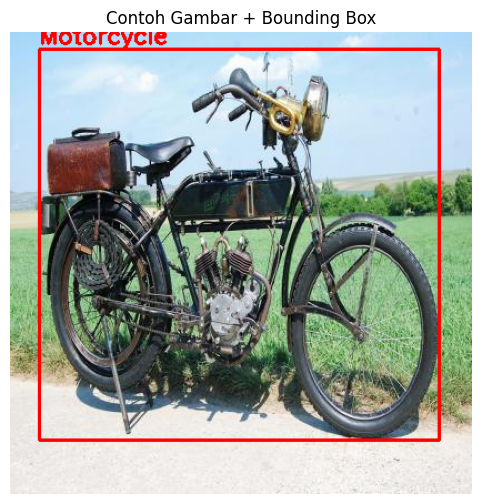

In [ ]:
import random

def plot_image_with_boxes(img_path, label_path, class_names):
    # img_path should be the full path to an image file
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    with open(label_path, 'r') as f:
        labels = f.readlines()

    for label in labels:
        cls, x, y, bw, bh = map(float, label.strip().split())
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, class_names[int(cls)], (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)

    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("Contoh Gambar + Bounding Box")
    plt.show()

# Get all images and labels
img_dir = os.path.join(dataset_path, "train", "images")
label_dir = os.path.join(dataset_path, "train", "labels")

# Choose a random image and its label file
img_files = os.listdir(img_dir)
random_image = random.choice(img_files)
random_image_path = os.path.join(img_dir, random_image)
random_label_path = os.path.join(label_dir, random_image[:-4] + '.txt')

plot_image_with_boxes(random_image_path, random_label_path, class_names)

Distribusi Ukuran Bounding Box

In [ ]:
import numpy as np

# Simpan semua ukuran bbox
bbox_sizes = []

# Loop semua file label
for lbl_file in os.listdir(train_lbl_dir):
    lbl_path = os.path.join(train_lbl_dir, lbl_file)
    with open(lbl_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) == 5:
                _, x_center, y_center, width, height = map(float, parts)
                # Simpan ukuran width dan height (normalized 0-1)
                bbox_sizes.append((width, height))

bbox_sizes = np.array(bbox_sizes)
widths = bbox_sizes[:, 0]
heights = bbox_sizes[:, 1]
areas = widths * heights  # Luas bbox

print(f"Jumlah bounding box: {len(areas)}")

Jumlah bounding box: 3200


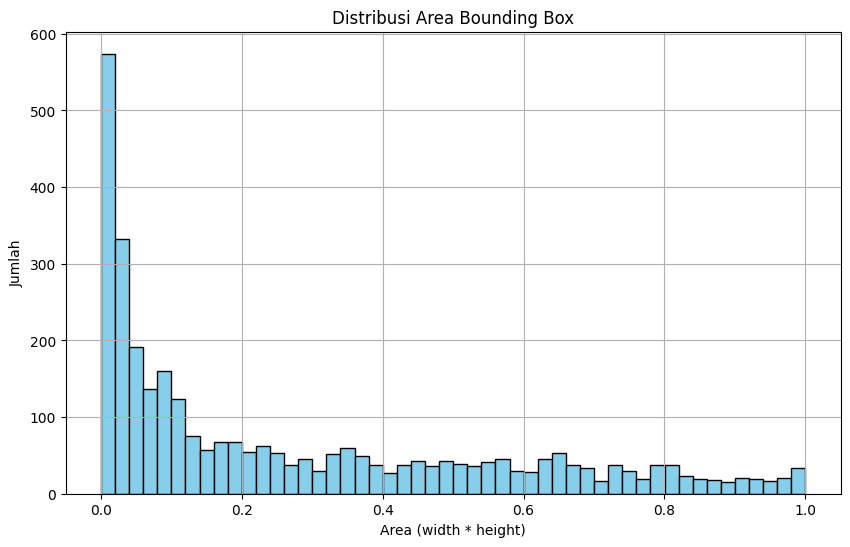

In [ ]:
# Plot histogram ukuran (area)
plt.figure(figsize=(10, 6))
plt.hist(areas, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribusi Area Bounding Box')
plt.xlabel('Area (width * height)')
plt.ylabel('Jumlah')
plt.grid(True)
plt.show()

# Model Training

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from ultralytics import YOLO
import os

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Path ke file konfigurasi data.yaml kamu
data_yaml_path = '/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/dataset.yaml'

# Inisialisasi model YOLOv8
model = YOLO('yolov8n.pt')

# Training
model.train(
    data=data_yaml_path,
    epochs=50,
    imgsz=416,
    batch=16,
    name='yolov8_vehicles_model',
    project='/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output',
    device=0
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 136MB/s]


Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/dataset.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=0, workers=8, project=/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output, name=yolov8_vehicles_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fra

100%|██████████| 755k/755k [00:00<00:00, 42.2MB/s]

Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,823 parameters, 3,011,807 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 172MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 4.3±8.3 ms, read: 0.1±0.0 MB/s, size: 51.8 KB)


train: Scanning /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/train/labels.cache... 1898 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1898/1898 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 2.1±3.0 ms, read: 0.1±0.0 MB/s, size: 32.9 KB)


val: Scanning /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.943G       1.13      2.549       1.33         35        416: 100%|██████████| 119/119 [12:08<00:00,  6.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.84it/s]

                   all        250        454      0.433      0.503      0.413      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.18G      1.201      1.957      1.362         34        416: 100%|██████████| 119/119 [00:23<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        250        454      0.582      0.359      0.416       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.18G      1.229      1.853      1.382         37        416: 100%|██████████| 119/119 [00:24<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.91it/s]

                   all        250        454      0.383      0.439      0.403      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       1.2G      1.207      1.786      1.372         37        416: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.43it/s]


                   all        250        454      0.558      0.344      0.392      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       1.2G      1.189      1.669      1.349         35        416: 100%|██████████| 119/119 [00:24<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]

                   all        250        454      0.525      0.352      0.403      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       1.2G      1.131       1.55      1.305         36        416: 100%|██████████| 119/119 [00:25<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]


                   all        250        454      0.355      0.482      0.406      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       1.2G      1.116      1.494      1.304         35        416: 100%|██████████| 119/119 [00:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.16it/s]


                   all        250        454      0.572      0.482      0.495      0.341

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50       1.2G      1.097      1.424      1.282         33        416: 100%|██████████| 119/119 [00:25<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


                   all        250        454      0.616      0.471      0.517      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50       1.2G      1.072      1.355      1.272         28        416: 100%|██████████| 119/119 [00:25<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]


                   all        250        454      0.654      0.486      0.508      0.373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       1.2G      1.043      1.269      1.252         47        416: 100%|██████████| 119/119 [00:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.72it/s]


                   all        250        454       0.72      0.447      0.498      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50       1.2G      1.035      1.245      1.243         37        416: 100%|██████████| 119/119 [00:23<00:00,  5.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.67it/s]

                   all        250        454      0.589       0.47      0.507      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50       1.2G       1.01      1.185      1.229         32        416: 100%|██████████| 119/119 [00:22<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]

                   all        250        454      0.607      0.549       0.56      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50       1.2G      0.996      1.147      1.216         41        416: 100%|██████████| 119/119 [00:23<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]

                   all        250        454      0.675      0.479      0.519      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50       1.2G     0.9735      1.104      1.203         31        416: 100%|██████████| 119/119 [00:23<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.20it/s]


                   all        250        454      0.648      0.461      0.545      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       1.2G     0.9318      1.049      1.187         29        416: 100%|██████████| 119/119 [00:24<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.18it/s]


                   all        250        454      0.686       0.55      0.562      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50       1.2G     0.9548      1.035      1.185         38        416: 100%|██████████| 119/119 [00:24<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]


                   all        250        454      0.601      0.525      0.556      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       1.2G     0.9181     0.9926      1.172         31        416: 100%|██████████| 119/119 [00:24<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]


                   all        250        454      0.637      0.451      0.532      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50       1.2G     0.9078      0.982      1.171         33        416: 100%|██████████| 119/119 [00:24<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.29it/s]

                   all        250        454      0.594      0.563      0.585      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50       1.2G     0.8893     0.9281      1.149         26        416: 100%|██████████| 119/119 [00:24<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]


                   all        250        454      0.678      0.502      0.555       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       1.2G     0.8748     0.9092      1.143         26        416: 100%|██████████| 119/119 [00:24<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.48it/s]

                   all        250        454      0.684      0.525      0.571      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      1.21G     0.8636     0.8852      1.136         38        416: 100%|██████████| 119/119 [00:24<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.89it/s]


                   all        250        454      0.732      0.465      0.561      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.23G     0.8514     0.8507      1.128         38        416: 100%|██████████| 119/119 [00:23<00:00,  5.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        250        454        0.7      0.536      0.593      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.23G     0.8338      0.822      1.118         44        416: 100%|██████████| 119/119 [00:23<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.58it/s]

                   all        250        454      0.692      0.525      0.588      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.23G     0.8085     0.8136      1.112         36        416: 100%|██████████| 119/119 [00:22<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]

                   all        250        454      0.571      0.527      0.529      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      1.23G     0.8135      0.814      1.107         37        416: 100%|██████████| 119/119 [00:23<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.37it/s]

                   all        250        454      0.586      0.536      0.548      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.23G     0.7965     0.7829      1.097         18        416: 100%|██████████| 119/119 [00:24<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


                   all        250        454      0.703      0.521      0.566      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.23G     0.7947     0.7725        1.1         37        416: 100%|██████████| 119/119 [00:24<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]


                   all        250        454       0.56      0.552      0.549      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.23G     0.7787     0.7559      1.091         24        416: 100%|██████████| 119/119 [00:24<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.44it/s]

                   all        250        454      0.613      0.499      0.541      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      1.23G     0.7595      0.732      1.082         28        416: 100%|██████████| 119/119 [00:24<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

                   all        250        454      0.526      0.529      0.566      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.23G     0.7566     0.7159      1.076         39        416: 100%|██████████| 119/119 [00:24<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.09it/s]


                   all        250        454      0.583      0.575      0.575      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      1.23G     0.7377     0.6914      1.072         21        416: 100%|██████████| 119/119 [00:24<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.38it/s]


                   all        250        454      0.641      0.494       0.54      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.25G     0.7373      0.681      1.068         33        416: 100%|██████████| 119/119 [00:23<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.23it/s]

                   all        250        454      0.589      0.506      0.538      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      1.26G     0.7291     0.6812      1.066         25        416: 100%|██████████| 119/119 [00:22<00:00,  5.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.68it/s]

                   all        250        454      0.701      0.496      0.538      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.27G     0.7249      0.671      1.065         36        416: 100%|██████████| 119/119 [00:23<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.65it/s]

                   all        250        454      0.688      0.522      0.577      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.27G     0.7101     0.6381      1.058         32        416: 100%|██████████| 119/119 [00:23<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.49it/s]

                   all        250        454      0.673      0.497      0.555      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.27G     0.6792     0.6139      1.038         22        416: 100%|██████████| 119/119 [00:24<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.54it/s]

                   all        250        454      0.765      0.471      0.569      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      1.27G     0.6928     0.6243      1.052         28        416: 100%|██████████| 119/119 [00:24<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        250        454      0.678      0.553      0.592      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.27G     0.6704     0.6001      1.035         32        416: 100%|██████████| 119/119 [00:24<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

                   all        250        454      0.708      0.517      0.574      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.27G     0.6691     0.6075      1.028         49        416: 100%|██████████| 119/119 [00:24<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.17it/s]

                   all        250        454      0.581      0.579      0.575      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.27G     0.6529     0.5785      1.027         37        416: 100%|██████████| 119/119 [00:24<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.46it/s]


                   all        250        454       0.64      0.547      0.576      0.442
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.27G     0.5652     0.4619     0.9678         17        416: 100%|██████████| 119/119 [00:24<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        250        454      0.648      0.526      0.571      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.27G     0.5478     0.4243     0.9574         16        416: 100%|██████████| 119/119 [00:23<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]

                   all        250        454      0.636      0.518      0.568      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.27G      0.529     0.4001     0.9463         14        416: 100%|██████████| 119/119 [00:22<00:00,  5.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.92it/s]

                   all        250        454      0.646      0.525      0.586      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.27G     0.5111     0.3953     0.9424         14        416: 100%|██████████| 119/119 [00:22<00:00,  5.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.72it/s]

                   all        250        454      0.641      0.542       0.57      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.27G      0.502     0.3728     0.9355         13        416: 100%|██████████| 119/119 [00:23<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        250        454      0.718      0.508      0.583      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.27G     0.4903     0.3601     0.9296         16        416: 100%|██████████| 119/119 [00:23<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.67it/s]

                   all        250        454      0.607      0.552      0.571      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.27G      0.477     0.3572     0.9273         19        416: 100%|██████████| 119/119 [00:23<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.39it/s]

                   all        250        454      0.624      0.527      0.576      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.27G     0.4658     0.3447     0.9141         13        416: 100%|██████████| 119/119 [00:23<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.19it/s]

                   all        250        454      0.618      0.553      0.568      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      1.27G     0.4549     0.3389     0.9211         13        416: 100%|██████████| 119/119 [00:22<00:00,  5.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]

                   all        250        454      0.676      0.522       0.58      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.27G     0.4518     0.3337     0.9164         10        416: 100%|██████████| 119/119 [00:22<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.61it/s]

                   all        250        454      0.657      0.547      0.587      0.445



50 epochs completed in 0.564 hours.
Optimizer stripped from /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/weights/last.pt, 6.2MB
Optimizer stripped from /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/weights/best.pt, 6.2MB

Validating /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/weights/best.pt...
Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.02it/s]


                   all        250        454      0.677      0.552      0.592      0.449
             Ambulance         50         64      0.726      0.844      0.817      0.714
                   Bus         30         46      0.639      0.615      0.663      0.566
                   Car         90        238      0.553      0.471      0.499      0.339
            Motorcycle         42         46      0.677      0.456      0.535       0.29
                 Truck         38         60       0.79      0.377      0.447      0.336
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f8375b8de90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
        

In [ ]:
# Evaluate model pada data validasi
metrics = model.val()
print(metrics)

Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 12.6±27.1 ms, read: 10.4±11.1 MB/s, size: 31.4 KB)


val: Scanning /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/valid/labels.cache... 250 images, 0 backgrounds, 0 corrupt: 100%|██████████| 250/250 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


                   all        250        454      0.679      0.553      0.592       0.45
             Ambulance         50         64      0.726      0.844      0.817      0.713
                   Bus         30         46      0.638      0.614      0.663      0.567
                   Car         90        238      0.561      0.472        0.5       0.34
            Motorcycle         42         46      0.677      0.456      0.536      0.291
                 Truck         38         60       0.79      0.377      0.446      0.338
Speed: 1.2ms preprocess, 3.0ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f837b1bf3d0>
curves: ['Precision-Recall(B)', 'F1-

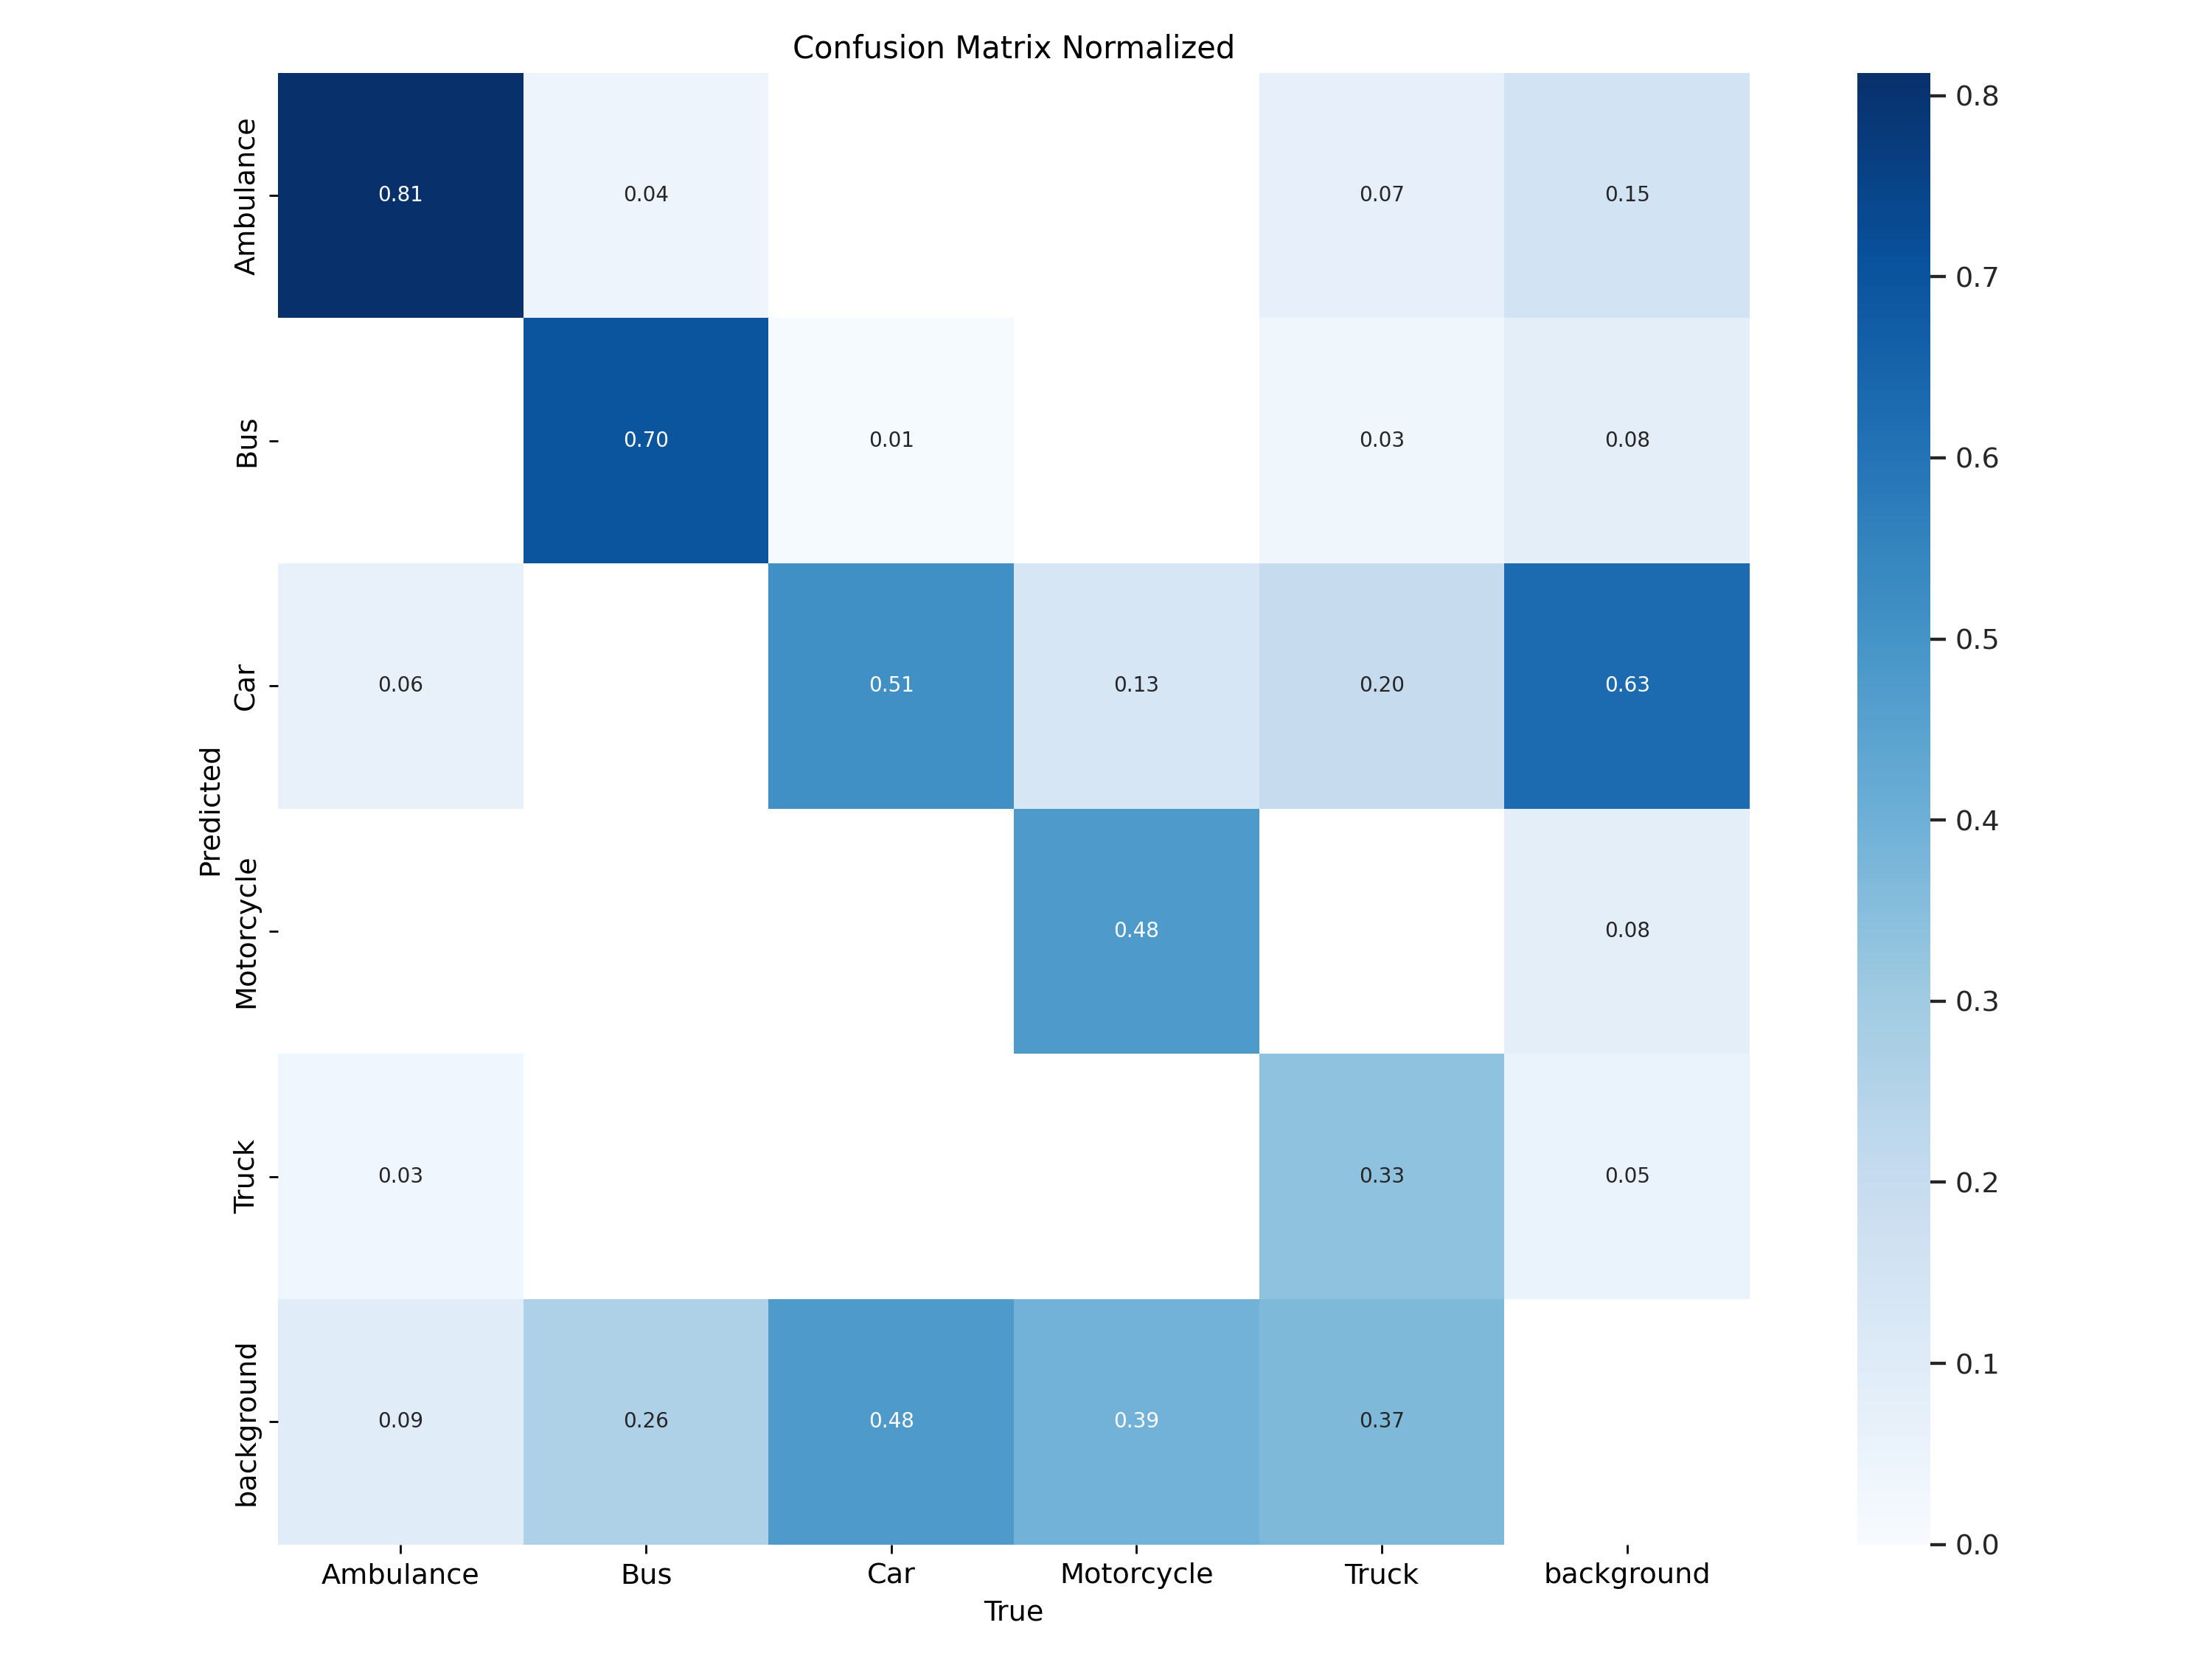

In [ ]:
from IPython.display import Image, display

project_path = '/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output'
image_path = os.path.join(project_path, 'yolov8_vehicles_model', 'confusion_matrix_normalized.png')

display(Image(filename=image_path))

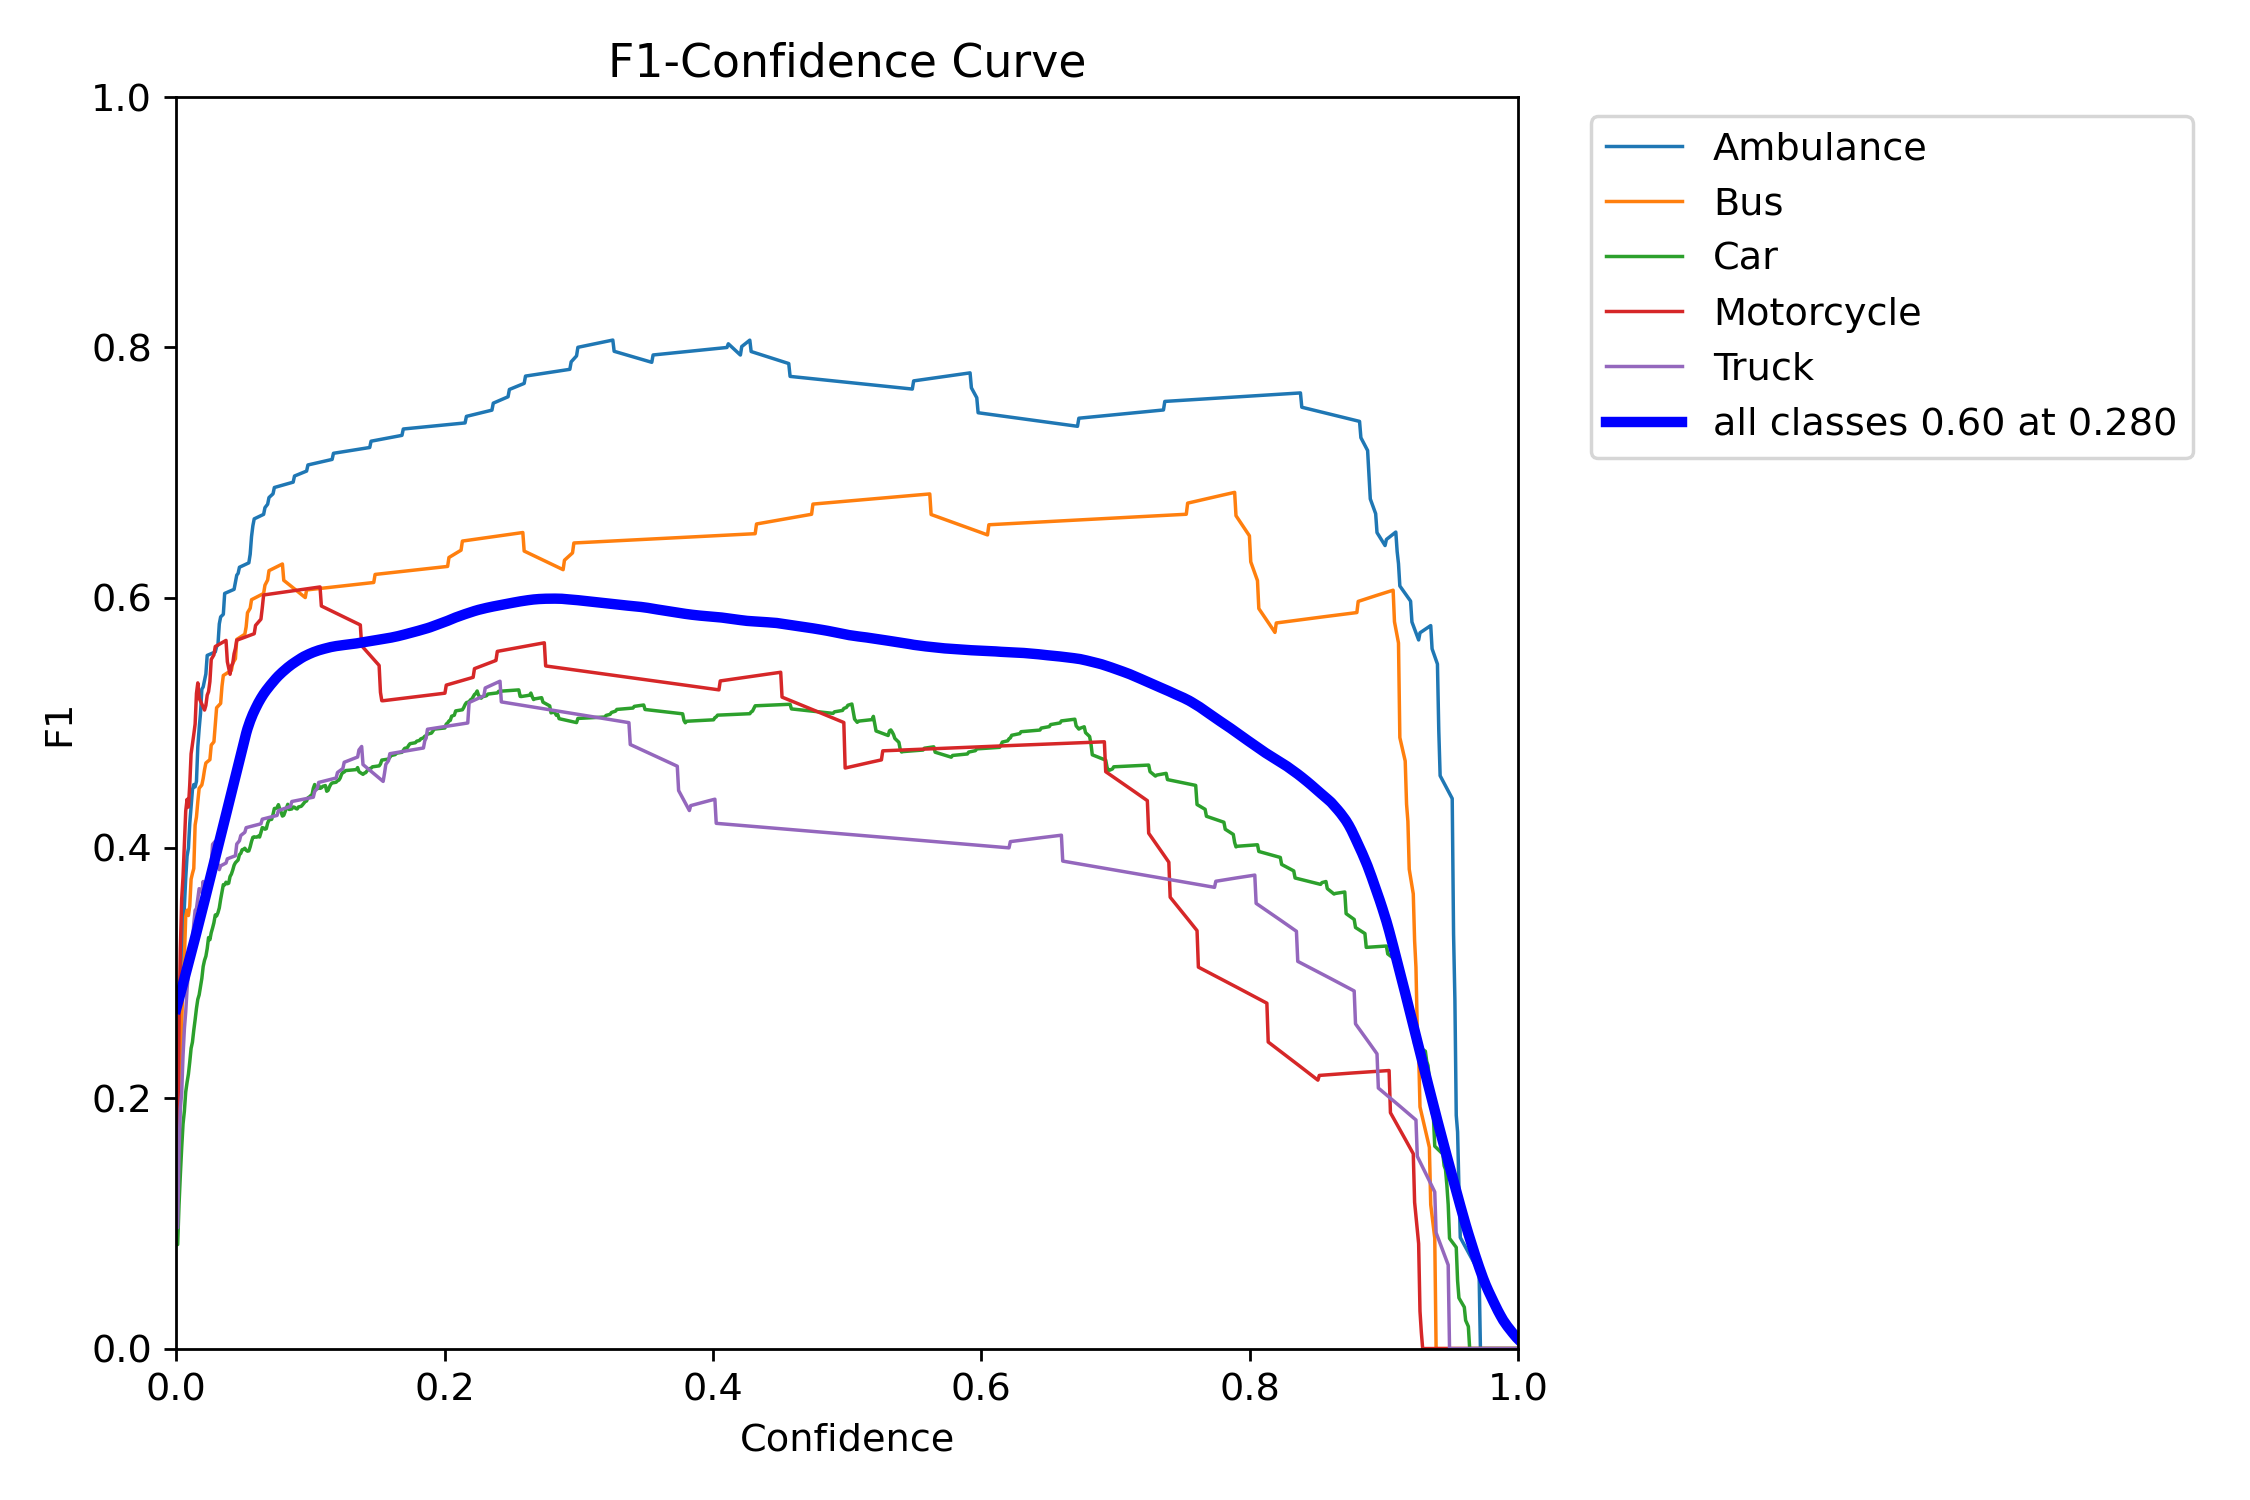

In [ ]:
project_path = '/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output'
image_path = os.path.join(project_path, 'yolov8_vehicles_model','F1_curve.png')
display(Image(filename=image_path))

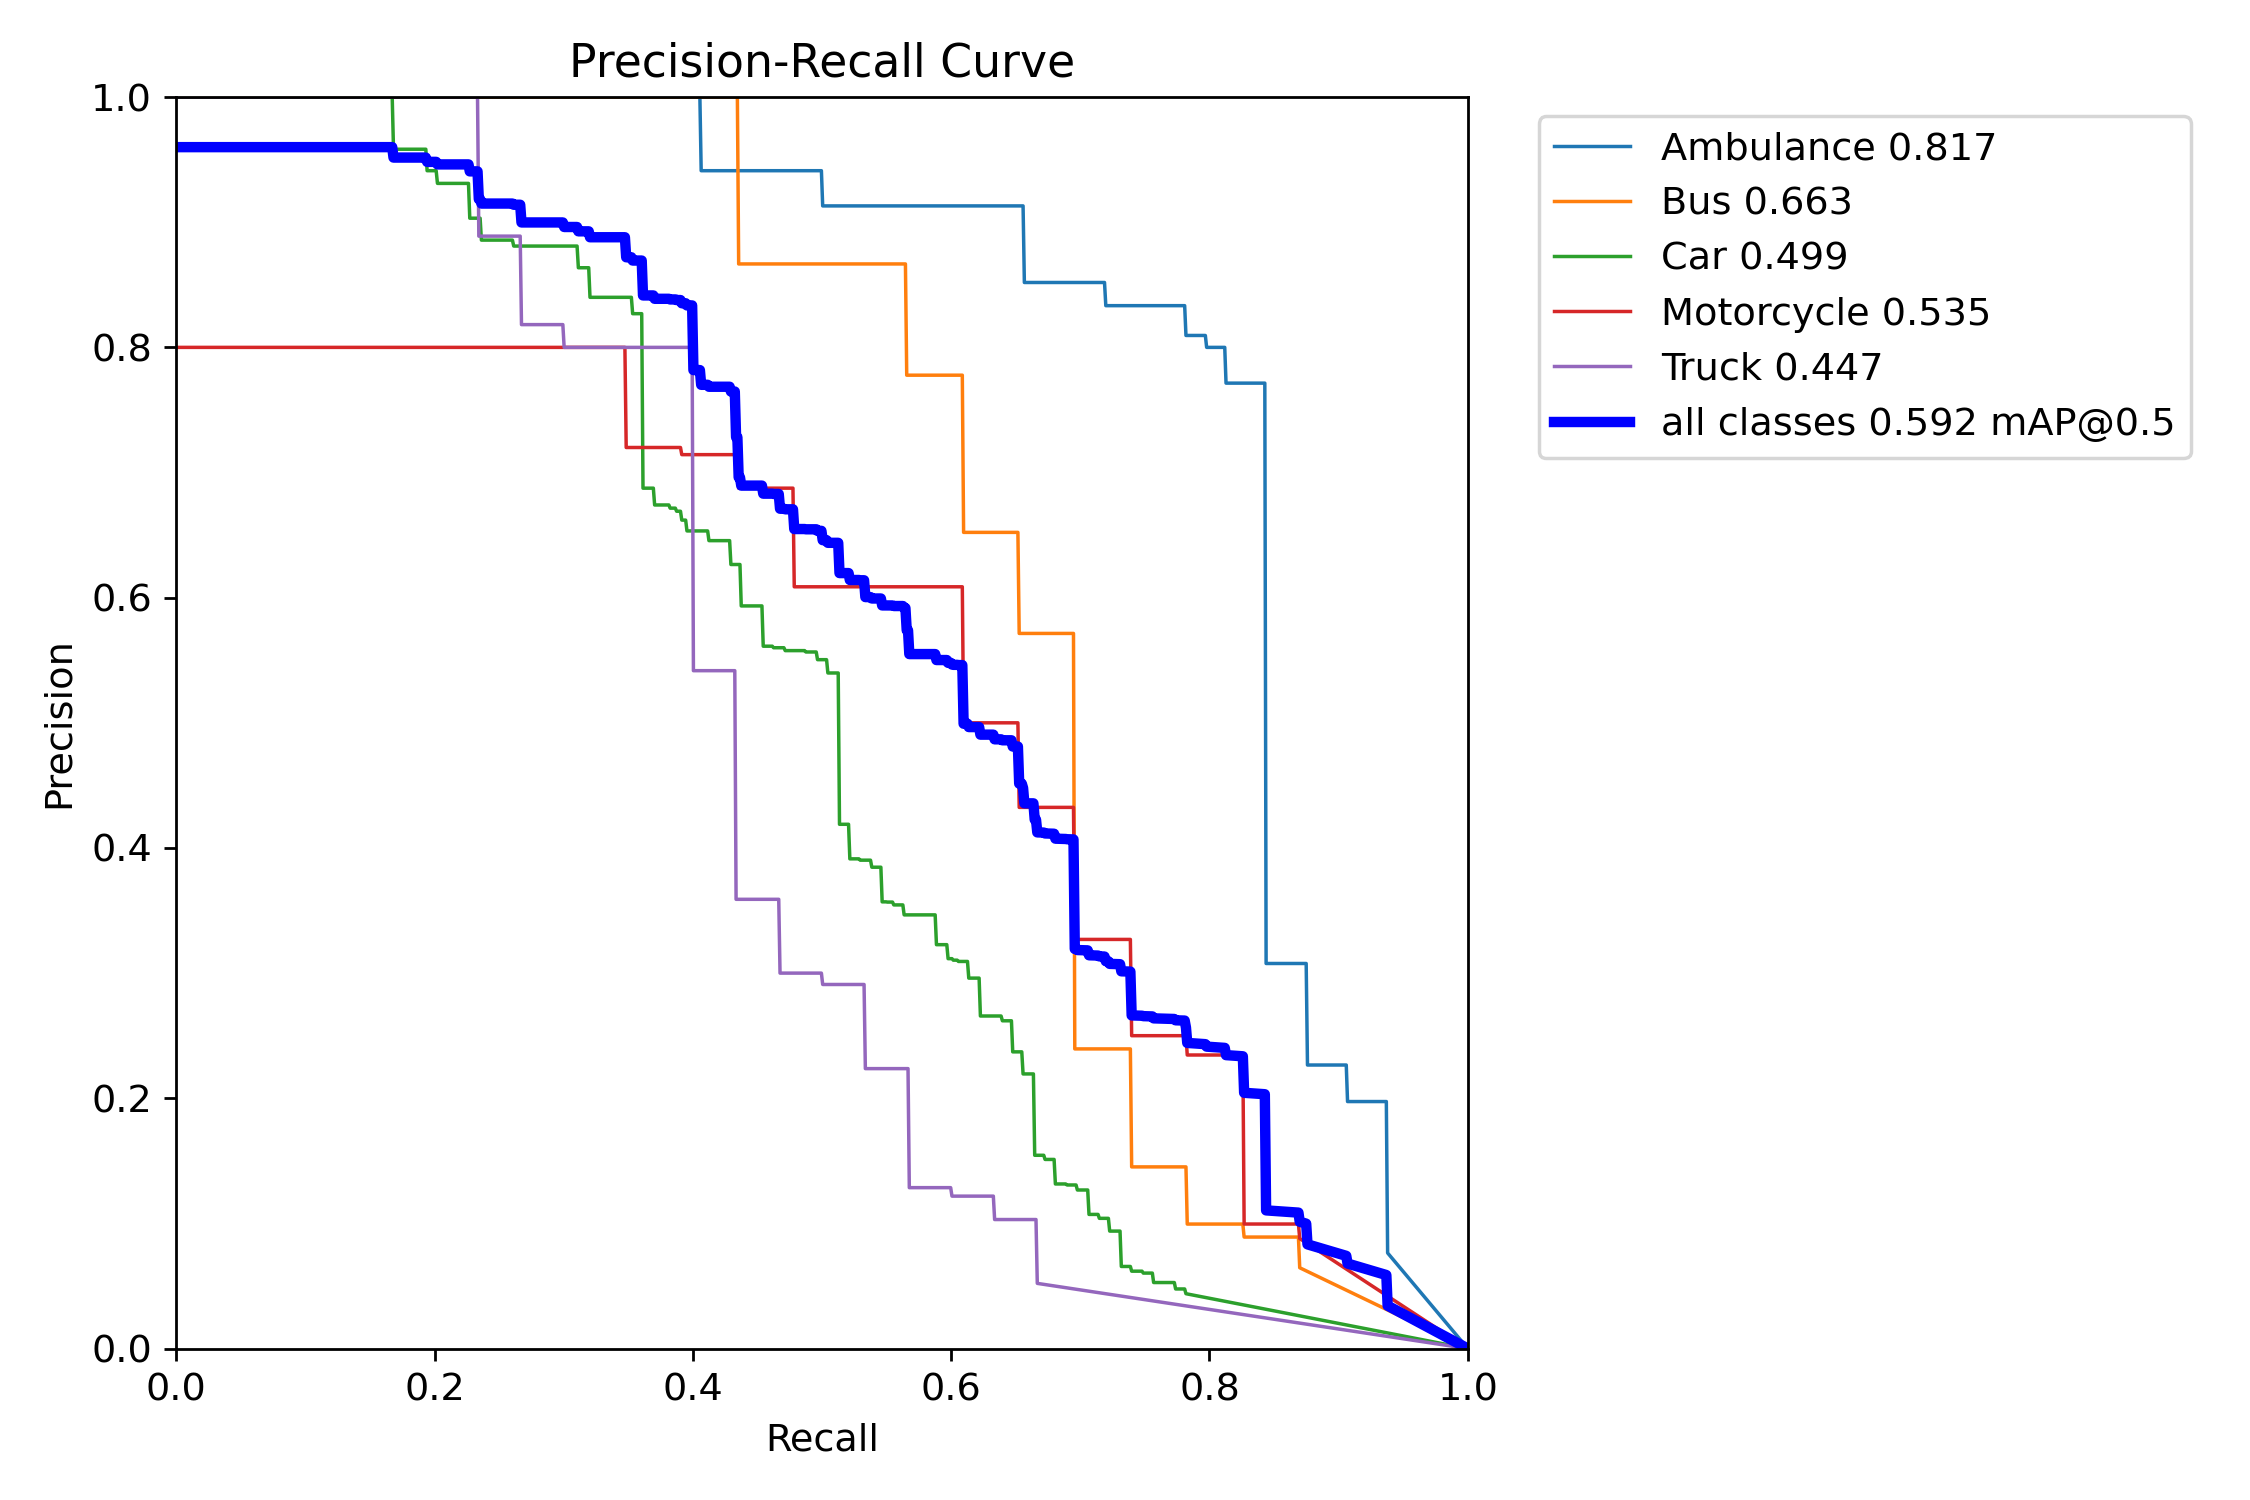

In [ ]:
image_path = os.path.join(project_path, 'yolov8_vehicles_model','PR_curve.png')
display(Image(filename=image_path))

In [ ]:
best_model = YOLO('/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/weights/best.pt')
metrics = best_model.val(split = 'test')

Ultralytics 8.3.124 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 2.3±5.0 MB/s, size: 26.2 KB)


val: Scanning /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/test/labels... 126 images, 0 backgrounds, 0 corrupt: 100%|██████████| 126/126 [00:52<00:00,  2.41it/s]

val: New cache created: /content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.49it/s]


                   all        126        258      0.735      0.587      0.654      0.526
             Ambulance         18         18      0.721      0.889       0.92      0.884
                   Bus         22         38      0.867      0.689       0.78      0.575
                   Car         60        150      0.696       0.67      0.686      0.458
            Motorcycle         12         32      0.568      0.188      0.278      0.207
                 Truck         14         20      0.822        0.5      0.607      0.507
Speed: 1.4ms preprocess, 3.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/val


In [ ]:
import os
from ultralytics import YOLO
from IPython.display import display, Image
from glob import glob
import shutil

# Load model
model = YOLO('/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/yolo_training_output/yolov8_vehicles_model/weights/best.pt')

# Ambil 5 gambar pertama dari folder test
test_folder = '/content/drive/MyDrive/Semester 6/PDM/VehiclesDataset/valid/images'
image_paths = sorted(glob(f"{test_folder}/*.jpg"))[:5]

# Lakukan prediksi dan simpan hasil
results = model(image_paths, save=True)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 416x416 3 Cars, 8.3ms
1: 416x416 3 Cars, 8.3ms
2: 416x416 2 Ambulances, 1 Car, 8.3ms
3: 416x416 2 Ambulances, 1 Car, 8.3ms
4: 416x416 4 Cars, 1 Truck, 8.3ms
Speed: 4.6ms preprocess, 8.3ms inference, 71.9ms postprocess per image at shape (1, 3, 416, 416)
Results saved to runs/detect/predict


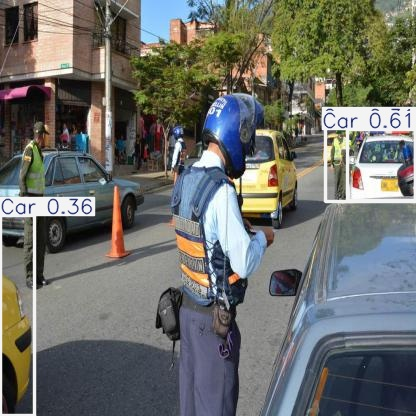

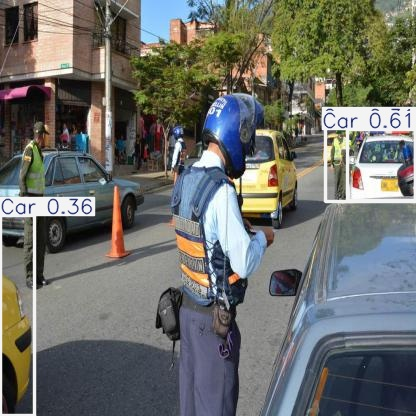

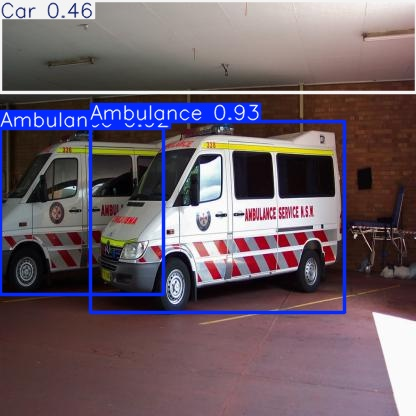

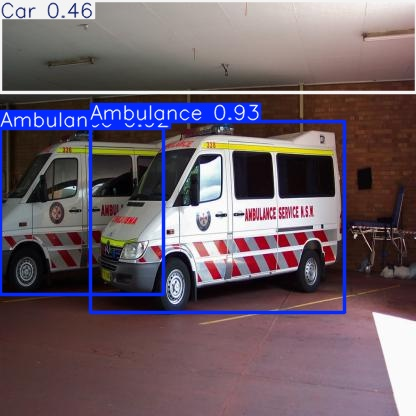

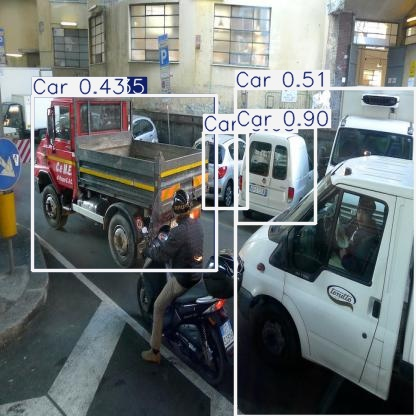

In [ ]:
# Tampilkan hasil prediksi (hasil otomatis disimpan ke runs/detect/predict/)
predict_folder = 'runs/detect/predict'

for path in image_paths:
    filename = os.path.basename(path)
    result_path = os.path.join(predict_folder, filename)
    display(Image(filename=result_path))